
# Simpson's Paradox with UC Berkeley (1973): Visualization-First Walkthrough

**Goal.** Use real microdata to visualize Simpson's paradox step-by-step while learning core **Matplotlib** and **Seaborn** concepts.

**Plan.** Aggregate → Facet by Department → Parity Plot → Standardize (optional)


In [1]:

# Imports, style, and helpers
import numpy as np, pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "figure.dpi": 110, "savefig.dpi": 300,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.grid": True, "grid.alpha": 0.25, "axes.titlesize": 12
})
sns.set_theme(context="talk", style="whitegrid")

def label_bars(ax, fmt="{:.1f}%"):
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.text(p.get_x()+p.get_width()/2, h, fmt.format(h*100),
                    ha="center", va="bottom", fontsize=10)

print("Libraries ready.")


Libraries ready.



## 0) Load the official microdata (one row per applicant)

**Columns:** `Year`, `Major` (A–F or Other), `Sex` (M/F), `Admission` (Accepted/Rejected)  
We'll focus on the classic **A–F** departments to reproduce the paradox cleanly.


In [2]:

path = "/content/berkeley.csv"
raw = pd.read_csv(path)
raw.head()


,Year,Major,Sex,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


In [3]:

# Filter to classic six departments and 1973
df = raw[(raw["Major"].isin(list("ABCDEF"))) & (raw["Year"]==1973)].copy()
df.rename(columns={"Major":"dept","Sex":"gender","Admission":"admit"}, inplace=True)
df["gender"] = df["gender"].map({"M":"Male","F":"Female"})
df["admit_bin"] = (df["admit"]=="Accepted").astype(int)
df.head()


,Year,dept,gender,admit,admit_bin
0,1973,C,Female,Rejected,0
1,1973,B,Male,Accepted,1
6,1973,F,Female,Accepted,1
9,1973,A,Male,Accepted,1
11,1973,B,Male,Accepted,1



## 1) Matplotlib basics — overall admission **rate** by gender (aggregate)

- Learn: `figure` vs `axes`, `plt.bar`, labels/ticks, honest axis (`0–1`), `savefig`.
- Teaching point: the aggregate view can **frame a misleading story**.


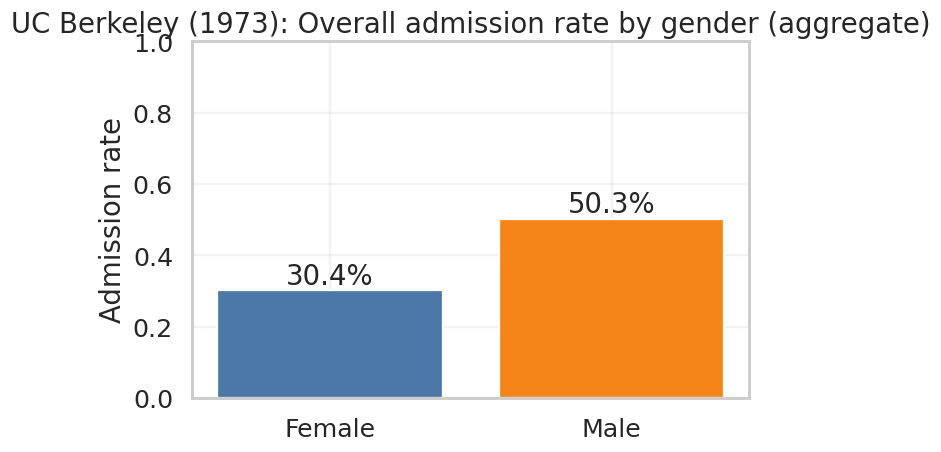

In [4]:

overall = df.groupby("gender")["admit_bin"].mean().reset_index(name="rate")

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.bar(overall["gender"], overall["rate"], color=["#4C78A8","#F58518"])
ax.set_ylim(0,1); ax.set_ylabel("Admission rate"); ax.set_xlabel("")
ax.set_title("UC Berkeley (1973): Overall admission rate by gender (aggregate)")
for x, y in zip(overall["gender"], overall["rate"]):
    ax.text(x, y, f"{y*100:.1f}%", ha="center", va="bottom")
fig.savefig("01_overall_rate_by_gender.png", bbox_inches="tight")
plt.show()



## 2) Seaborn facets — within-department rates (Simpson's paradox reveal)

- Learn: `groupby` → tidy frame of rates & Ns, `catplot(col=...)` for small multiples, annotate **N**.  
- Teaching point: comparing **within** departments flips/collapses the aggregate story.


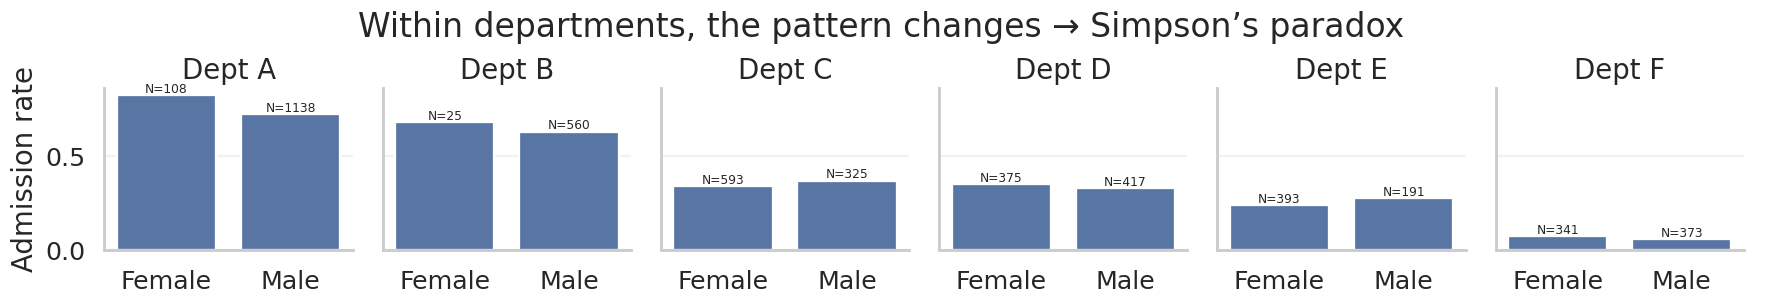

In [5]:

# Compute within-department rates and Ns
dept_rates = (df.groupby(["dept","gender"])["admit_bin"]
                .agg(rate="mean", N="size")
                .reset_index())

g = sns.catplot(data=dept_rates, x="gender", y="rate", col="dept",
                kind="bar", height=3, aspect=0.9, sharey=True)
for ax, d in zip(g.axes.flat, sorted(dept_rates["dept"].unique())):
    sub = dept_rates[dept_rates["dept"]==d]
    for p, (_, row) in zip(ax.patches, sub.iterrows()):
        ax.text(p.get_x()+p.get_width()/2, p.get_height(), f"N={row['N']}",
                ha="center", va="bottom", fontsize=8)
g.set_titles("Dept {col_name}"); g.set_ylabels("Admission rate"); g.set_xlabels("")
g.fig.suptitle("Within departments, the pattern changes → Simpson’s paradox", y=1.05)
plt.show()



## 3) Parity plot (Matplotlib) — female vs male admission rate by department

- Learn: scatter with annotations, identity line `y=x`, size encoding = **N** per dept.  
- Reading: points **above** the diagonal → departments where **women's rate > men's**; below → the reverse.


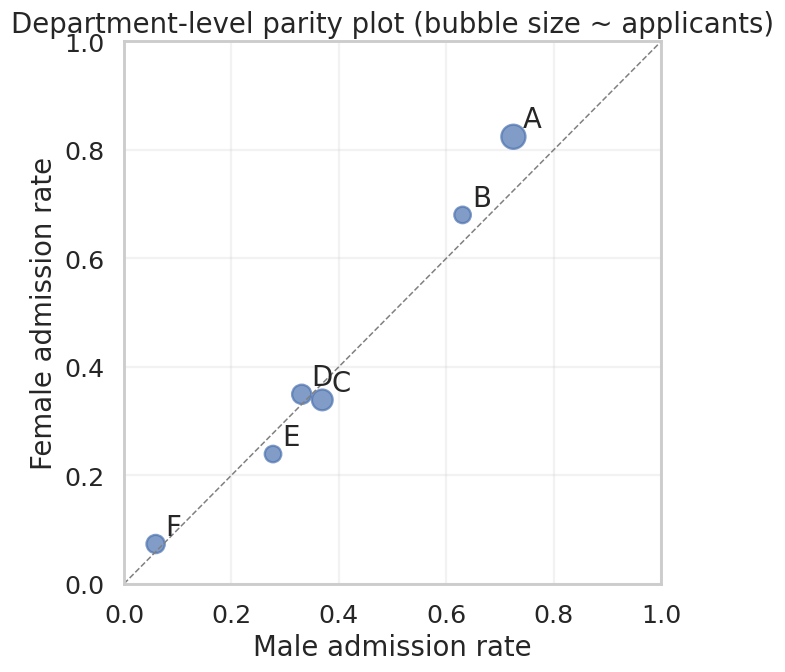

In [6]:

# Pivot to male/female columns; compute dept totals for size
pivot = dept_rates.pivot(index="dept", columns="gender", values="rate")
sizes = df.groupby("dept").size().reindex(pivot.index)
labels = pivot.index.tolist()

fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
ax.plot([0,1],[0,1], ls="--", c="gray", lw=1)
sc = ax.scatter(pivot["Male"], pivot["Female"], s=(sizes/5), alpha=0.7)  # size scaled
for d, x, y in zip(labels, pivot["Male"], pivot["Female"]):
    ax.annotate(d, (x, y), textcoords="offset points", xytext=(6,6))
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("Male admission rate"); ax.set_ylabel("Female admission rate")
ax.set_title("Department-level parity plot (bubble size ~ applicants)")
fig.savefig("02_parity_plot.png", bbox_inches="tight")
plt.show()



## 4) Optional: department-standardized comparison (composition-adjusted)

- Learn: compute a **common department mix** and form weighted rates per gender.  
- Teaching point: visualization **reveals** the confounder (department mix); a simple **standardization** produces one fair comparison.


/tmp/ipython-input-1116889498.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=std_rates, x="gender", y="std_rate", ax=ax, palette=["#4C78A8","#F58518"])


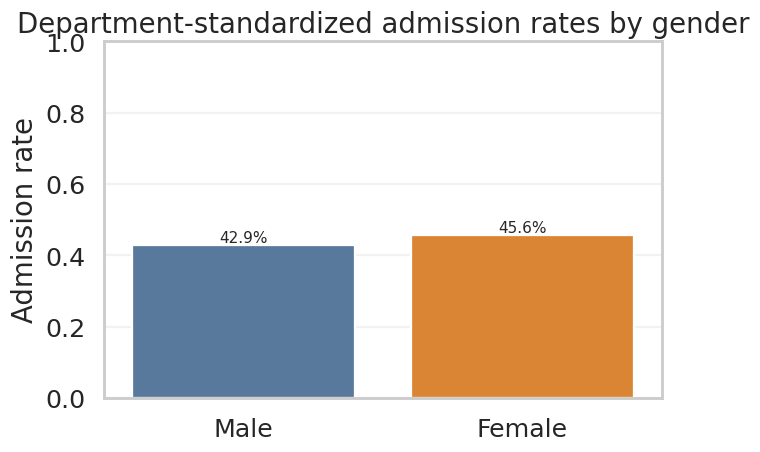

In [7]:

# Build department mix from all applicants
mix = (df.groupby("dept").size() / len(df)).reindex(pivot.index)

# Weighted rates
std_rates = pd.DataFrame({
    "gender": ["Male","Female"],
    "std_rate": [
        (pivot["Male"]*mix).sum(),
        (pivot["Female"]*mix).sum()
    ]
})

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
sns.barplot(data=std_rates, x="gender", y="std_rate", ax=ax, palette=["#4C78A8","#F58518"])
label_bars(ax); ax.set_ylim(0,1)
ax.set_title("Department-standardized admission rates by gender")
ax.set_ylabel("Admission rate"); ax.set_xlabel("")
fig.savefig("03_standardized_rates.png", bbox_inches="tight")
plt.show()



## 5) (Optional) Model confirmation (logistic regression with department controls)

- Learn: GLM binomial with department indicators; the **gender coefficient** shrinks when conditioning on `dept`.  
- Teaching point: **viz reveals**, **model confirms**; we report both.


In [8]:

import statsmodels.formula.api as smf
# Aggregate to dept x gender to avoid expanding to all rows in GLM with weights
tbl = (df.groupby(["dept","gender"])["admit_bin"]
         .agg(successes="sum", total="size").reset_index())
tbl["rate"] = tbl["successes"]/tbl["total"]

# Fit GLM with Binomial family and frequency weights
model = smf.glm("rate ~ C(gender) + C(dept)", data=tbl,
                family=__import__('statsmodels').genmod.families.Binomial(),
                freq_weights=tbl["total"]).fit()
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   rate   No. Observations:                   12
Model:                            GLM   Df Residuals:                     4832
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1818.9
Date:                Thu, 16 Oct 2025   Deviance:                       8.1228
Time:                        02:43:23   Pearson chi2:                     7.81
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0481      0.09


## Mini-exercises (pick one if you have time)
- Add **Wilson 95% CIs** to each department’s bars in the facet chart.  
- Re-order department facets by **applicant volume**.  
- Save each figure with `dpi=300` and add it to your slide deck.
